In [2]:
import numpy as np
import matplotlib.pyplot as plt

# Problem Set 9: Simulating a Morris-Lecar Neuron

All problems that require an answer are marked by $\color{violet}{\text{text in violet}}$ so you don't miss them.

# Background on the Morris-Lecar model
Most neuroscientists know the story of the [Hodgkin Huxley model](https://en.wikipedia.org/wiki/Hodgkin%E2%80%93Huxley_model) and the squid giant axon. But did you can get nearly the same range of spiking behaviors with half the parameters? Enter the **Morris-Lecar model**, one of the most popular conductance-based models in neuroscience.

Developed by Catherine Morris and Harold Lecar from recordings of the [giant acorn barnacle](https://en.wikipedia.org/wiki/Balanus_nubilus), it captures the spiking dynamics of neurons in terms of two dynamical parameters: a membrane potential $V$ and a recovery variable $W$, the latter of which captures the fraction of open potassium ion channels in the neuron.

Because potassium ion channels open/close more slowly than other voltage-gated channels, they become a rate-limiting step for action potentials; by comparison, all other ion channels can be assumed to achieve their steady-state values instantaneously. This **separation of timescales** is what allows Morris and Lecar to describe the entire action potential generation process in terms of only two dynamic variables.

[Read more about the Morris-Lecar model on Scholarpedia](http://www.scholarpedia.org/article/Morris-Lecar_model).

[Read more about the Morris-Lecar model on Wikipedia](https://en.wikipedia.org/wiki/Morris%E2%80%93Lecar_model).

## Introducing the model

The Morris-Lecar model is defined by the following pair of diffential equations:

\begin{align}
  C \frac{dV}{dt} & ~=~ - g_\mathrm{Ca} \cdot M_\mathrm{ss}(V) \cdot (V-V_\mathrm{Ca}) - g_\mathrm{K} \cdot W \cdot (V-V_\mathrm{K}) - g_\mathrm{L} \cdot (V-V_\mathrm{L}) + I\\[5pt]
  \frac{dW}{dt} & ~=~ \frac{W_\mathrm{ss}-W}{T_\mathrm{W}(V)}
\end{align}

Let's start with the biophysical parameters: $C$ is the membrane capacitance, $g_\mathrm{Ca}$, $g_\mathrm{K}$, and $g_\mathrm{L}$ are ion-specific conductances ("L" is a leak conductance, basically a catch-all for all ions other than potassium and calcium), and $V_\mathrm{Ca}$, $V_\mathrm{K}$, and $V_\mathrm{L}$ are corresponding ion-specific reversal potentials.

The dynamics of voltage-gated ion channels are captured by $M_\mathrm{ss}(V)$ and $W$, describing how calcium and potassium conductances change as a function of the membrane potential $V$. $M_\mathrm{ss}(V)$ is called that because voltage-dependent changes in calcium channel conductances are fast compared to those of potassium channels, effectively instantly reaching its *steady-state* value (hence the *ss*). While $M$ is still a function of the cell's membrane potential, it can be treated as constant once we condition on $V$.

$W$ evolves more slowly- the second equation shows the dynamics by which it reaches its steady-state value $W_\mathrm{ss}(V)$ as a function of time. Our remaining parameter $T_\mathrm{W}(V)$ captures just that, the membrane-potential-dependent-rate at which $W$ approaches $W_\mathrm{ss}$.

Now for the last bit of equations- we have to define $M_\mathrm{ss}(V)$, $W_\mathrm{ss}(V)$, and $T_\mathrm{W}(V)$. These are defined in terms of five parameters that Morris and Lecar fit to their data:

\begin{align}
M_\mathrm{ss}(V) & ~=~ (1 + \tanh[(V-V_1)/V_2])/2\\
W_\mathrm{ss}(V) & ~=~ (1 + \tanh[(V-V_3)/V_4])/2\\
T_\mathrm{W}(V) & ~=~ T_0/\cosh[(V-V_3)/(2V_4)]\\
\end{align}

## Problem 1. Understanding the channel steady-state dynamics

Before we go further, let's quickly look at how these last three equations change as a function of V:

We'll use V1-V4 values derived from data.

In [3]:
V1 = -1.2 #high number, never changes, low number stays maximal
V2 = 18.0
V3 = 12.0
V4 = 17.4
T0 = 15

$\color{violet}{\text{1a. Write lambda functions defining $M_{ss}$, $W_{ss}$, and $T_W$ as functions of an input parameter $V$.}}$ 

In [4]:
Mss = lambda V: (1+np.tanh((V-V1)/V2))/2
Wss = lambda V: (1+np.tanh((V-V3)/V4))/2
Tw  = lambda V: T0/(np.cosh((V-V3)/(2*V4)))

$\color{violet}{\text{1b. Now, plot the value of $M_{ss}$, $W_{ss}$, and $T_w$ over a biologically reasonable range of membrane potentials.}}$


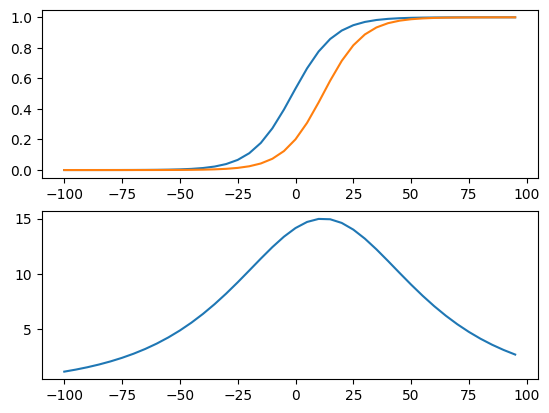

In [5]:
Vs = np.arange(-100,100,5)
fig, ax = plt.subplots(nrows=2)
ax[0].plot(Vs, Mss(Vs))
ax[0].plot(Vs, Wss(Vs))
ax[1].plot(Vs, Tw(Vs))

$\color{violet}{\text{1c. What do these plots tell us about the behavior of $M_{ss}$, $W_{ss}$, and $T_W$ as functions of the membrane potential?}}$

$M_\mathrm{ss}$ and $W_\mathrm{ss}$ are telling us that ...
$T_\mathrm{W}$ is telling us that ...

Wss are telling us how much the conductance would change as a function of voltage, Tw is telling us the rate of change of the conductance of voltage as the voltage is slowly increased

$\color{violet}{\text{1d. What about $V_1$ - $V_4$- what are they doing?}}$

Try either looking at the equations or fiddling around with the values of these parameters in your plotting code, to determine the effect they are having on $M_\mathrm{ss}(V)$ and $W_\mathrm{ss}(V)$

V1 and V3 ... sets voltage at which conductance starts changing, sorta like x axis offset

V2 and V4 ... the slope at which conductance changes, how quickly conductance changes to max.

## Problem 2. Simulating the model
Let's define two sets of parameters for the Morris-Lecar model: basic electrical properties of the cell, and voltage sensitivities and reaction times of the ion channels.

The first set of parameters are pretty consistent across neurons. Here are some reasonable values:

In [6]:
param_cell = {'membrane_capacitance':         20.0,   # uF/cm^2
              
              'calcium_reversal_potential':   120.0,  # mV
              'potassium_reversal_potential': -80.0,  # mV
              'leak_reversal_potential':      -60.0,  # mV
              
              'calcium_conductance':          4.4,    # mS/cm^2
              'potassium_conductance':        8.0,    # mS/cm^2
              'leak conductance':             2.0,    # mS/cm^2
             }

The second set of ion channel parameters are different for different cell types. Here's one set of values to get you started:

In [7]:
param_channels = {'V1': -1.2,   # mV
                  'V2': 18.0,   # mV
                  'V3': 12.0,   # mV
                  'V4': 17.4,   # mV
                  'T0': 15  # ms^-1 we didn't talk about this- it's just a scaling term on the rate of change of W
                 }

$\color{violet}{\text{2a. First, complete this function that simulates one timestep of the model.}}$

In [8]:
def morris_lecar_step(V, W, param_cell, param_channels, I, dt):
    
    C   = param_cell['membrane_capacitance']
    gCa = param_cell['calcium_conductance']
    gK  = param_cell['potassium_conductance']
    gL  = param_cell['leak conductance']
    vCa = param_cell['calcium_reversal_potential']
    vK  = param_cell['potassium_reversal_potential']
    vL  = param_cell['leak_reversal_potential']
    
    V1  = param_channels['V1']
    V2  = param_channels['V2']
    V3  = param_channels['V3']
    V4  = param_channels['V4']
    T0  = param_channels['T0']
    
    # add your previously defined lambdas here:
    Mss = lambda V: (1+np.tanh((V-V1)/V2))/2
    Wss = lambda V: (1+np.tanh((V-V3)/V4))/2
    Tw  = lambda V: T0/(np.cosh((V-V3)/(2*V4)))
    
    

    # calculate change in V and W according to the Morris-Lecar model:
    dvdt = ((-gCa * Mss(V) * (V-vCa)) - (gK*W*(V-vK))-(gL*(V-vL))+I) / C
    dwdt = (Wss(V)-W) / (Tw(V))
    
    # update V and W using first-order Euler's method:
    V2 = V + dvdt * dt
    W2 = W + dwdt * dt
    
    return V2, W2, Mss(V), Wss(V), Tw(V)


$\color{violet}{\text{2b. Now, using your single-timestep code above, simulate the response of the model neuron to a one-second current injection.}}$

Complete this code snippet to simulate two seconds of the dynamics of the Morris-Lecar model, and plot V and W as functions of time.

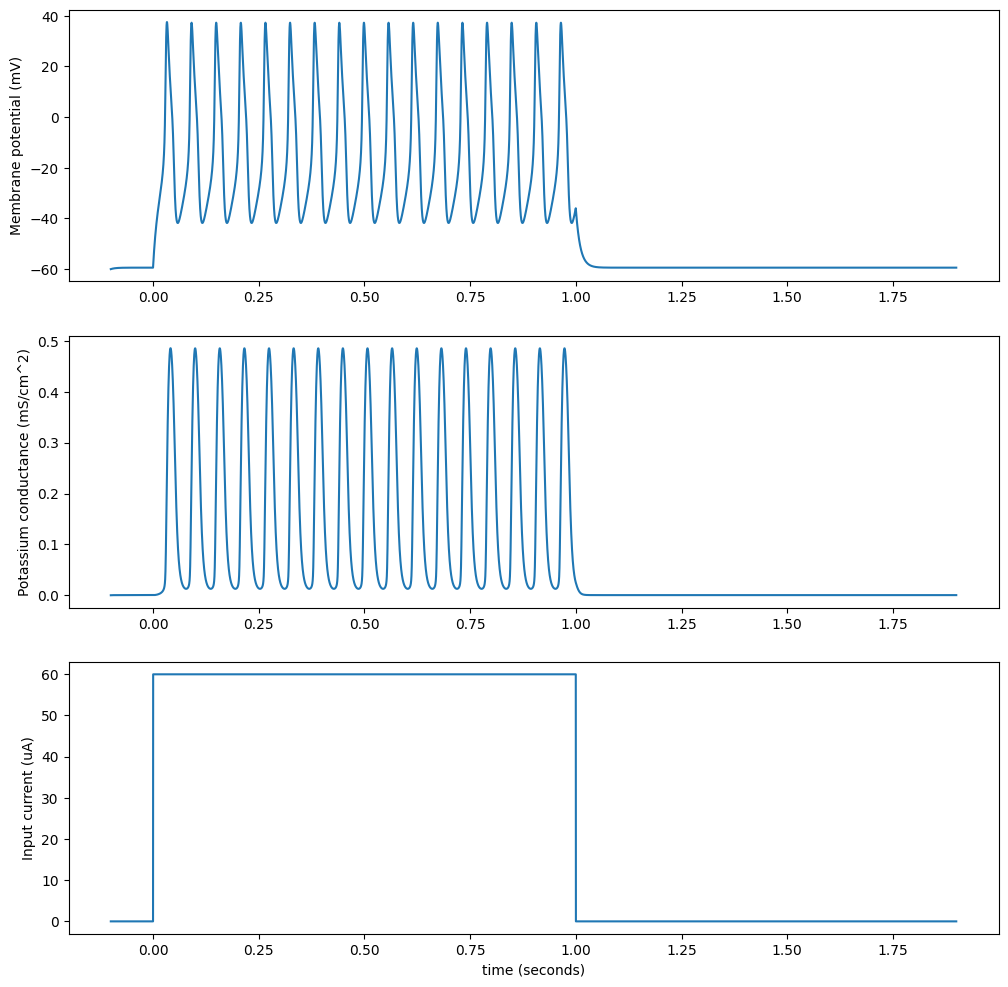

In [12]:
V = -60.0     # initial conditions for membrane potential and potassium conductance
W = 0.0

tmax = 2000.  # simulation time in milliseconds
dt = 0.1      # simulation timestep in milliseconds

stim_on = 0.1        # stimulus onset time in seconds
stim_duration = 1.   # stimulus duration in seconds
stim_amp = 60.0      # stimulus amplitude in uA

time = np.arange(0, tmax, dt)/1000.  # simulation timestamps
time = time - stim_on  # align time to current onset, just for fun
simtime = len(time)    # compute the number of simulation timesteps

I = np.zeros(simtime) # create the input current
I[int(stim_on * 10000):int((stim_duration+stim_on) * 10000)] = stim_amp


v_store = np.zeros(simtime)  # store history of V
w_store = np.zeros(simtime)  # store history of W
for t in range(simtime):
    V, W, mss, wss, tw = morris_lecar_step(V, W, param_cell, param_channels, I[t], dt)
    v_store[t] = V
    w_store[t] = W
    ... # replace this with your code


fig, ax = plt.subplots(3, figsize=(12,12))
ax[0].plot(time, v_store)
ax[0].set_ylabel('Membrane potential (mV)')

ax[1].plot(time, w_store)
ax[1].set_ylabel('Potassium conductance (mS/cm^2)')

ax[2].plot(time, I)
ax[2].set_ylabel('Input current (uA)')
ax[2].set_xlabel('time (seconds)')
plt.show()

## Problem 3. Constructing a F-I curve
A common analysis in neurophysiology is to plot the frequency-current (F-I) curve of a recorded neuron. To do so, you inject the cell with different amounts of current, and plot for each amount the cell's spiking frequency (in spikes/second).

$\color{violet}{\text{3a. Plot an F-I curve for the Morris-Lecar model using the parameter values from part 2.} \\
\text{Test currents of $0 \mu A$ to $90 \mu A$, using a 5-second current injection.}\\
\text{Consider a spike to occur when the membrane potential passes above $0 mV$.}}$

In [13]:
def simulate(I):
    V = -60.0     # initial conditions for membrane potential and potassium conductance
    W = 0.0

    tmax = 5000.  # simulation time in milliseconds
    dt = 0.1      # simulation timestep in milliseconds]

    time = np.arange(0, tmax, dt)/1000.  # simulation timestamps
    time = time - stim_on  # align time to current onset, just for fun
    simtime = len(time)    # compute the number of simulation timesteps
    
    assert len(I) == simtime, 'uh oh'

    #I = np.zeros(simtime) # create the input current
    #I[int(stim_on * 10000):int(stim_duration * 10000)] = stim_amp


    v_store = np.zeros(simtime)  # store history of V
    w_store = np.zeros(simtime)  # store history of W
    for t in range(simtime):
        V, W, mss, wss, tw = morris_lecar_step(V, W, param_cell, param_channels, I[t], dt)
        v_store[t] = V
        w_store[t] = W
        
    num_spikes = np.count_nonzero(np.diff((v_store > 0).astype(int)) == 1)
    
    return V, W, num_spikes



stim_sweep = np.arange(0, 90, 5)

spike_list = []

stim_on=0.1
stim_duration=5

tmax=5000
dt=0.1
time = np.arange(0, tmax, dt)/1000.  # simulation timestamps
time = time - stim_on  # align time to current onset, just for fun
simtime = len(time)    # compute the number of simulation timesteps

for this_stim_amp in stim_sweep:
    
    I = np.zeros(simtime) # create the input current
    I[int(stim_on * 10000):int(stim_duration * 10000)] = this_stim_amp
    
    _, _, num_spikes = simulate(I)
    
    spike_list.append(num_spikes/stim_duration)

Text(0.5, 0, 'current (ua)')

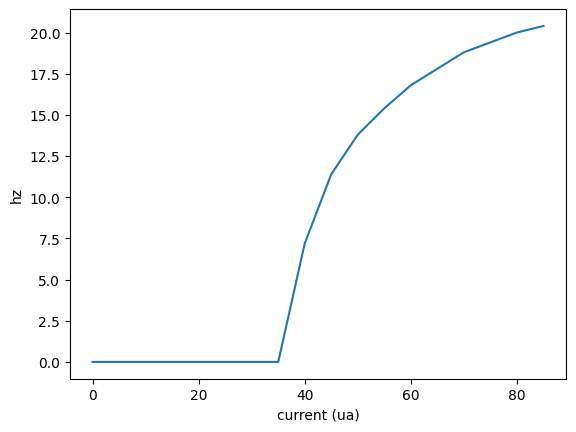

In [14]:
fig, ax = plt.subplots()
ax.plot(stim_sweep, spike_list)
ax.set_ylabel('hz')
ax.set_xlabel('current (ua)')

$\color{violet}{\text{3b. What happens to your spike rate if you go above $90 \mu A$? Why? }}$

Above 90 uA, the spike rate... goes down to ~0, because never goes under-threshold to respike

## Problem 4. A different spiking behavior

If we change the channel activation parameters of the model, we can produce different looking F-I curves.

$\color{violet}{\text{4a. As in problem 3, construct an F-I curve of the model using the revised channel parameter settings provided below,}\\
\text{over an input range of $40 - 120 \mu A$.}}$

In [15]:
param_channels_2 = {'V1': -1.2,   # mV
                    'V2': 18.0,   # mV
                    'V3': 2.0,   # mV
                    'V4': 30.0,   # mV
                    'T0': 1/0.04  # ms^-1
                   }

def morris_lecar_step(V, W, param_cell, param_channels, I, dt):
    
    C   = param_cell['membrane_capacitance']
    gCa = param_cell['calcium_conductance']
    gK  = param_cell['potassium_conductance']
    gL  = param_cell['leak conductance']
    vCa = param_cell['calcium_reversal_potential']
    vK  = param_cell['potassium_reversal_potential']
    vL  = param_cell['leak_reversal_potential']
    
    V1  = param_channels_2['V1']
    V2  = param_channels_2['V2']
    V3  = param_channels_2['V3']
    V4  = param_channels_2['V4']
    T0  = param_channels_2['T0']
    
    # add your previously defined lambdas here:
    Mss = lambda V: (1+np.tanh((V-V1)/V2))/2
    Wss = lambda V: (1+np.tanh((V-V3)/V4))/2
    Tw  = lambda V: T0/(np.cosh((V-V3)/(2*V4)))
    
    

    # calculate change in V and W according to the Morris-Lecar model:
    dvdt = ((-gCa * Mss(V) * (V-vCa)) - (gK*W*(V-vK))-(gL*(V-vL))+I) / C
    dwdt = (Wss(V)-W) / (Tw(V))
    
    # update V and W using first-order Euler's method:
    V2 = V + dvdt * dt
    W2 = W + dwdt * dt
    
    return V2, W2, Mss(V), Wss(V), Tw(V)

In [16]:
def simulate(I):
    V = -60.0     # initial conditions for membrane potential and potassium conductance
    W = 0.0

    tmax = 5000.  # simulation time in milliseconds
    dt = 0.1      # simulation timestep in milliseconds]

    time = np.arange(0, tmax, dt)/1000.  # simulation timestamps
    time = time - stim_on  # align time to current onset, just for fun
    simtime = len(time)    # compute the number of simulation timesteps
    
    assert len(I) == simtime, 'uh oh'

    #I = np.zeros(simtime) # create the input current
    #I[int(stim_on * 10000):int(stim_duration * 10000)] = stim_amp


    v_store = np.zeros(simtime)  # store history of V
    w_store = np.zeros(simtime)  # store history of W
    for t in range(simtime):
        V, W, mss, wss, tw = morris_lecar_step(V, W, param_cell, param_channels, I[t], dt)
        v_store[t] = V
        w_store[t] = W
        
    num_spikes = np.count_nonzero(np.diff((v_store > 0).astype(int)) == 1)
    
    return V, W, num_spikes



stim_sweep = np.arange(40, 120, 5)

spike_list = []

stim_on=0.1
stim_duration=5

for this_stim_amp in stim_sweep:
    
    I = np.zeros(simtime) # create the input current
    I[int(stim_on * 10000):int(stim_duration * 10000)] = this_stim_amp
    
    _, _, num_spikes = simulate(I)
    
    spike_list.append(num_spikes/stim_duration)

Text(0.5, 0, 'current (ua)')

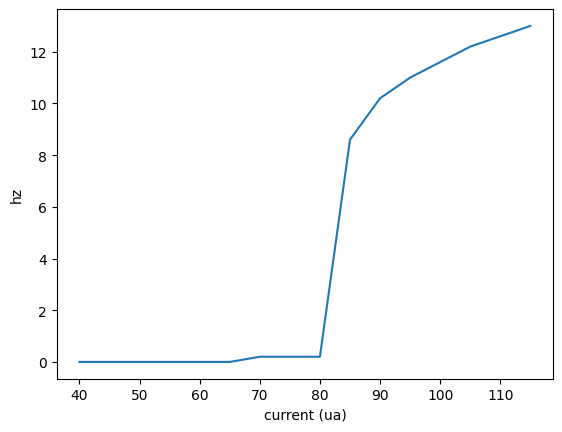

In [17]:
fig, ax = plt.subplots()
ax.plot(stim_sweep, spike_list)
ax.set_ylabel('hz')
ax.set_xlabel('current (ua)')

$\color{violet}{\text{4b. Use the F-I curve to pick three values of $I$ that capture different behaviors of the model.}\\
\text{Plot the model's response to a one-second input for each value of $I$, and describe what you find.}}$

In [18]:
stim_amp_4b = [50, 85, 110]

def simulate(I):
    V = -60.0     # initial conditions for membrane potential and potassium conductance
    W = 0.0

    tmax = 5000.  # simulation time in milliseconds
    dt = 0.1      # simulation timestep in milliseconds]

    time = np.arange(0, tmax, dt)/1000.  # simulation timestamps
    time = time - stim_on  # align time to current onset, just for fun
    simtime = len(time)    # compute the number of simulation timesteps
    
    assert len(I) == simtime, 'uh oh'

    #I = np.zeros(simtime) # create the input current
    #I[int(stim_on * 10000):int(stim_duration * 10000)] = stim_amp


    v_store = np.zeros(simtime)  # store history of V
    w_store = np.zeros(simtime)  # store history of W
    for t in range(simtime):
        V, W, mss, wss, tw = morris_lecar_step(V, W, param_cell, param_channels, I[t], dt)
        v_store[t] = V
        w_store[t] = W
        
    num_spikes = np.count_nonzero(np.diff((v_store > 0).astype(int)) == 1)
    
    return v_store, w_store, num_spikes



spike_list = []
v_list=[]


stim_on=0.1
stim_duration=1

for this_stim_amp in stim_amp_4b:
    
    I = np.zeros(simtime) # create the input current
    I[int(stim_on * 10000):int(stim_duration * 10000)] = this_stim_amp
    
    v_store, _, num_spikes = simulate(I)
    v_list.append(v_store)
    
    spike_list.append(num_spikes/stim_duration)

Text(0, 0.5, 'Membrane potential (mV)')

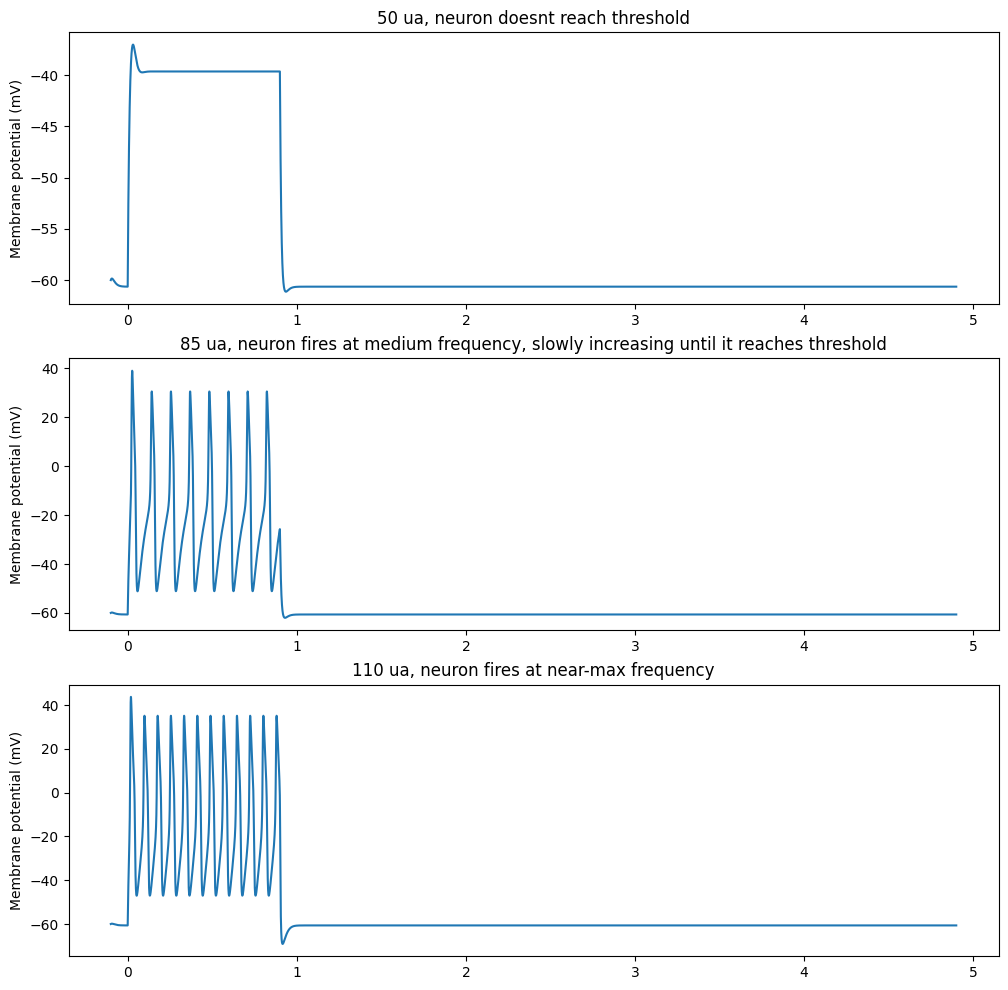

In [19]:
time = np.arange(0, tmax, dt)/1000.  # simulation timestamps
time = time - stim_on  # align time to current onset, just for fun

fig, ax = plt.subplots(3, figsize=(12,12))
ax[0].plot(time, v_list[0])
ax[0].set_title('50 ua, neuron doesnt reach threshold')
ax[0].set_ylabel('Membrane potential (mV)')

ax[1].plot(time, v_list[1])
ax[1].set_title('85 ua, neuron fires at medium frequency, slowly increasing until it reaches threshold')
ax[1].set_ylabel('Membrane potential (mV)')

ax[2].plot(time, v_list[2])
ax[2].set_title('110 ua, neuron fires at near-max frequency')
ax[2].set_ylabel('Membrane potential (mV)')

## Bonus problem: thinking in matrix notation
Throughout this homework, we treated $V$ and $W$ as two separate variables, which is fine- but it can be a good mental exercise to try to think of how you could repackage this system using matrix notation. For Morris-Lecar, doing so also allows us to put our model into the form needed for simulation using the exponential Euler method.

$\color{violet}{\text{Bonus Problem. Re-write the Morris-Lecar equations for $V$ and $W$ in terms of a single vector $Y$,}\\ \text{whose dynamics take the form}
\begin{align}
\frac{dy}{dt} & ~=~ A(y) - B(y) y
\end{align}
}$